# Model 3 
In model 3 we applied a bidirectional LSTM with 1 hidden layer, batching size of 200, window size of 60 and a rolling window with overlap of 1 on a data sample of 900 samples.

In [3]:
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


%load_ext tensorboard

### Class stock_trainer 
The class defines the variables and functions required to import the data, preprocess it and finally analyze and predict the future prices.

In [8]:
class stock_trainer():
    def __init__(self) -> None:
        self.timestep = 1
        self.train_size = 0
        self.test_size = 0
        self.window_size = 60
        self.overlap = 1
        self.train_split = 0.8
        self.idx_train = None
        self.data_size = 900
        self.num_features = 0
        self.batch_size = 200

    # The load_data function imports the dataset from the csv file obtained from Kaggle
        
    def load_data(self):
        data = pd.read_csv("AAPL.csv", usecols=([1, 2, 3, 4, 6]))
        self.num_features = data.shape[1]
        self.dataset = data.values[-1 * self.data_size:,:]

    # The function extract_data determines the test size based on the self.train_size parameter. 
    # It then splits the data into train and test sets. the split data is next scaled using
    # MinMaxScaler(). Next each data set converted into data samples - X and target data - y.  The X 
    # values for train and test are generated based on the self.window_size. Finally the X_train and 
    # y_train samples are shuffled. All X and y arrays along with the Scaler are returned to the main function.
    

    def extract_data(self):
        num_days = self.dataset.shape[0]

        #Set train and test size
        self.train_size = int(np.floor(num_days * self.train_split))
        self.test_size = num_days - self.train_size

        #Split train and test data
        # scaler = MinMaxScaler(feature_range=(0, 1))
        # self.dataset = scaler.fit_transform(self.dataset).squeeze()
        train_days = self.dataset[:self.train_size,:]
        test_days = self.dataset[self.train_size:,:]

        #Scale data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train_days = scaler.fit_transform(train_days).squeeze()
        scaled_test_days = scaler.transform(test_days).squeeze()

        #Build numpy arrays
        self.X_train = []
        self.y_train = []
        self.X_test = []
        self.y_test = []

        for i in range(0, self.train_size - self.window_size - 1, self.overlap):
            self.X_train.append(scaled_train_days[i:(i + self.window_size),:])
            self.y_train.append(scaled_train_days[i + self.window_size, 4])

        for i in range(0, self.test_size - self.window_size - 1, self.overlap):
            self.X_test.append(scaled_test_days[i:(i + self.window_size),:])
            self.y_test.append(scaled_test_days[i + self.window_size, 4])

        self.X_train = np.array(self.X_train)
        self.y_train = np.array(self.y_train)
        self.X_test = np.array(self.X_test)
        self.y_test = np.array(self.y_test)

        #Shuffle train data
        self.idx_train = np.random.choice(self.X_train.shape[0], self.X_train.shape[0], replace=False)
        self.X_train = self.X_train[self.idx_train,:,:]
        self.y_train = self.y_train[self.idx_train]

        return self.X_train, self.y_train, self.X_test, self.y_test, scaler

    # The build_model function defines the LSTM model. the model is complied and is fitted with 
    # the X_train and y_train  samples
    
    def build_model(self):
        #create RNN model   
        model = tf.keras.Sequential()
        model.add(Bidirectional(LSTM(250, return_sequences=True)))
        # model.add(Dropout(0.4))
        model.add(Bidirectional(LSTM(250)))
        model.add(Dropout(0.4))
        # model.add(layers.Dense(100))
        # model.add(layers.Dense(1))
        # Add a layer with 1 internal units.
        model.add(layers.Dense(1, activation='linear'))

        optimizer = keras.optimizers.Adam(learning_rate=0.01)
        model.compile(loss='mean_absolute_error', optimizer=optimizer)
        # callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        # log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        reduce_lr = [tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2, min_lr=0.00001)
                     ]
        model.fit(self.X_train, self.y_train, epochs=200, callbacks=reduce_lr, batch_size=self.batch_size, verbose=1)
        return model
    
# The prediction function uses the model and the test samplesto predict and calculate the MAE for 
# train and test samples

def prediction(X_train, y_train, X_test, y_test, batch_size, model):
    y_pred_train = model.predict(X_train)
    train_score = math.sqrt(mean_absolute_error(y_train, y_pred_train))
    print('Train MAE Score: %.2f' % (train_score))

    y_pred_test = model.predict(X_test)
    test_score = math.sqrt(mean_absolute_error(y_test, y_pred_test))
    print('Test MAE Score: %.2f' % (test_score))
    return y_pred_test

# The scheduler functions was defined for modifying the Learning rate during the model training. 

def scheduler(epoch, lr):
    if epoch < 10:
      return lr
    else:
      return lr * tf.math.exp(-0.1)

### Execution

In [9]:
# Training
trainer = stock_trainer()  
trainer.load_data()
X_train, y_train, X_test, y_test, scaler = trainer.extract_data()
model = trainer.build_model()

Epoch 1/200
4/4 [==============================] - 6s 76ms/step - loss: 2.6942
Epoch 2/200
4/4 [==============================] - 0s 54ms/step - loss: 1.4334
Epoch 3/200
4/4 [==============================] - 0s 53ms/step - loss: 0.5747
Epoch 4/200
4/4 [==============================] - 0s 53ms/step - loss: 0.3056
Epoch 5/200
4/4 [==============================] - 0s 52ms/step - loss: 0.2385
Epoch 6/200
4/4 [==============================] - 0s 54ms/step - loss: 0.2317
Epoch 7/200
4/4 [==============================] - 0s 53ms/step - loss: 0.1830
Epoch 8/200
4/4 [==============================] - 0s 54ms/step - loss: 0.1476
Epoch 9/200
4/4 [==============================] - 0s 53ms/step - loss: 0.1387
Epoch 10/200
4/4 [==============================] - 0s 53ms/step - loss: 0.1132
Epoch 11/200
4/4 [==============================] - 0s 52ms/step - loss: 0.0722
Epoch 12/200
4/4 [==============================] - 0s 51ms/step - loss: 0.0789
Epoch 13/200
4/4 [==============================]

In [6]:
#%tensorboard --logdir logs/fit

### Prediction and Plotting

In [10]:
# Prediction
y_pred = prediction(X_train, y_train, X_test, y_test, trainer.batch_size, model)
scaled_y_pred = np.append(np.insert(y_pred, 0, 0, axis=1), np.zeros((y_pred.shape[0], 3)), axis=1)
scaled_y_pred = scaler.inverse_transform(scaled_y_pred)[:,1]
scaled_y_test = np.append(np.insert(y_test.reshape((y_test.shape[0], 1)), 0, 0, axis=1), np.zeros((y_test.shape[0], 3)), axis=1)
scaled_y_test = scaler.inverse_transform(scaled_y_test)[:,1]


Train MAE Score: 0.11
Test MAE Score: 0.19


In [11]:
print(f"Predicted Next Day Price: ${scaled_y_pred[-1]:.2f}, Actual Next Day Price: ${scaled_y_test[-1]:.2f}")

daily_changes = np.sign(np.diff(scaled_y_test))
daily_changes_pred = np.sign(np.diff(scaled_y_pred))
directional_acc = 1 - np.count_nonzero(daily_changes - daily_changes_pred) / daily_changes.shape[0]
print(f"Directional Accuracy: {directional_acc:.3f}")

percentage_acc = 1 - np.mean(np.abs((scaled_y_pred - scaled_y_test) / scaled_y_test))
print(f"Accuracy: {percentage_acc:.2f}")

Predicted Next Day Price: $131.43, Actual Next Day Price: $131.21
Directional Accuracy: 0.407
Accuracy: 0.97


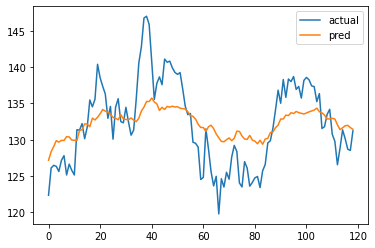

In [12]:
# Plotting
# plt.plot(scaled_X_train)
# plt.plot(np.arange(X_train.shape[0], X_train.shape[0] + X_test.shape[0]), scaled_X_test)
# plt.plot(np.arange(X_train.shape[0], X_train.shape[0] + X_test.shape[0]), scaled_y_pred)
# plt.legend(["train", "actual", "pred"])
plt.plot(scaled_y_test)
plt.plot(scaled_y_pred)
plt.legend(["actual", "pred"])
plt.show()